In [1]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
# import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from nltk import PorterStemmer
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
from ipywidgets import IntProgress
from IPython.display import display
import datetime
from matplotlib import dates
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.dates as mdates
from ipywidgets import IntProgress
from IPython.display import display

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class Patient(object):
    totalCount = 0
    diagnosedTimeDict = dict()
    idToNameDict = dict()
    with open('../0_dataset/diagnosedTweetsPatch2') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            diagnosedTimeDict[line[0]] = datetime.datetime.strptime(line[3], "%Y-%m-%d %H:%M:%S")
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.name = Patient.idToNameDict[userId]
        self.df0 = pd.read_csv('../0_dataset/DepressionUsersTweets/Patch2_data/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = self.df0.drop_duplicates(subset='Date', keep='first')
        self.df0 = self.df0.set_index('Date')
        self.df0.index = pd.to_datetime(self.df0.index)

        self.diagnosedTime = Patient.diagnosedTimeDict[userId]
        timeDuration1 = self.diagnosedTime - datetime.timedelta(days=90)
        timeDuration2 = self.diagnosedTime - datetime.timedelta(days=180)
        self.df1 = self.df0.loc[str(self.diagnosedTime):str(timeDuration1)]
        self.df2 = self.df0.loc[str(timeDuration1):str(timeDuration2)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [3]:
class Ordinary(object):
    totalCount = 0
    idToNameDict = dict()
    with open('../0_dataset/sampleOrdinaryIDtoName') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.df0 = pd.read_csv('../0_dataset/OrdinaryUsersTweets/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = self.df0.drop_duplicates(subset='Date', keep='first')
        self.df0 = self.df0.set_index('Date')
        self.df0.index = pd.to_datetime(self.df0.index)
        self.df0 = self.df0.sort_index(ascending=False)
        
        self.newestTime = self.df0.index[0]
        self.name = Ordinary.idToNameDict[userId]
        timeDuration1 = self.newestTime - datetime.timedelta(days=90)
        timeDuration2 = self.newestTime - datetime.timedelta(days=180)
        
        self.df1 = self.df0.loc[str(self.newestTime):str(timeDuration1)]
        # Weird bug...
        if self.df1.empty:
            self.df1 = self.df0.loc[str(timeDuration1):str(self.newestTime)]
        # Weird bug...
        self.df2 = self.df0.loc[str(timeDuration1):str(timeDuration2)]
        if self.df2.empty:
            self.df2 = self.df0.loc[str(timeDuration2):str(timeDuration1)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [4]:
def replace_by_symbols(txt):
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"idk", 'i do not know', txt)   # idk: i don't know
    txt = re.sub(r"tbh", 'to be honest', txt)   # tbh: to be honest
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"i\'m", 'i am', txt)
    txt = re.sub(r"you\'re", 'you are', txt)
    txt = re.sub(r"he\'s", 'he is', txt)
    txt = re.sub(r"she\'s", 'she is', txt)
    txt = re.sub(r"it\'s", 'it is', txt)
    txt = re.sub(r"we\'re", 'we are', txt)
    txt = re.sub(r"they\'re", 'they are', txt)
    txt = re.sub(r"isn\'t", 'is not', txt)
    txt = re.sub(r"don\'t", 'do not', txt)
    txt = re.sub(r"doesn\'t", 'does not', txt)
    txt = re.sub(r"didn\'t", 'did not', txt)
    txt = re.sub(r"wasn\'t", 'was not', txt)
    txt = re.sub(r"weren\'t", 'were not', txt)
    txt = re.sub(r"haven\'t", 'have not', txt)
    txt = re.sub(r"can\'t", 'can not', txt)
    txt = re.sub(r"couldn\'t", 'could not', txt)
    txt = re.sub(r"wouldn\'t", 'would not', txt)
    txt = re.sub(r"shouldn\'t", 'should not', txt)
    txt = re.sub(r"&amp", '', txt)
    return txt

In [5]:
def initializeProgressBar(_max, initDescription='(Init)'):
    progress = IntProgress()
    progress.max = _max
    progress.description = initDescription
    display(progress)
    return progress

In [6]:
%%time
patients = dict()
with open('../0_dataset/patch2PatientIDs') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patients[patient] = Patient(patient)
        # break
print('Total patient: {0}'.format(len(patients)))

Total patient: 137
CPU times: user 1.64 s, sys: 80 ms, total: 1.72 s
Wall time: 1.73 s


In [7]:
%%time
ordinarys = dict()
with open('../0_dataset/sampleOrdinaryIDs') as openFile:
    for ordinary in openFile.readlines():
        ordinary = ordinary.strip()
        ordinarys[ordinary] = Ordinary(ordinary)
print('Total ordinary: {0}'.format(len(ordinarys)))

Total ordinary: 150
CPU times: user 1.27 s, sys: 36 ms, total: 1.3 s
Wall time: 1.32 s


In [8]:
groupTexts = []
baseTexts = []

for key in patients.keys():
    groupTexts.append(replace_by_symbols('\n'.join(patients[key].getText())))

for key in ordinarys.keys():
    baseTexts.append(replace_by_symbols('\n'.join(ordinarys[key].getText())))

# corpus = base_texts + group_texts

In [9]:
def createVectorizer(ngrams):
    vectorizer = TfidfVectorizer(stop_words="english", token_pattern='(?u)\\b[a-zA-Z]\\w{2,}\\b', ngram_range = (ngrams,ngrams), min_df=1)
    return vectorizer

def getTFIDFScores(vectorizer, tfidfResult):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidfResult.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    words = []
    scores = []
    for item in sorted_scores:
        words.append(item[0])
        scores.append(item[1])
    return words, scores

def showTFIDFResult(texts, top=50, ngrams=1):
    vectorizer = createVectorizer(ngrams)
    tfidfResult = vectorizer.fit_transform(texts)
    words, scores = getTFIDFScores(vectorizer, tfidfResult)
    for i in range(50):
        print(words[i],scores[i])
    return (words, scores)

# Case 1: Without Filtering

In [10]:
tfidfResult = showTFIDFResult(groupTexts)

just 14.9922925695
like 14.2186021267
love 11.2246149052
know 7.82981092551
good 6.55024209926
want 6.5006245372
people 6.16942597916
really 5.89481801847
shit 5.82028700686
fuck 5.66121942597
today 5.53596012249
time 5.53544830923
got 5.44267336216
day 5.33567621026
did 5.22603430068
going 4.92213599179
think 4.88580269033
fucking 4.76046141048
need 4.67508757844
new 4.49956551713
gonna 4.46101194092
feel 4.30237368038
life 4.18769057261
happy 4.14265577234
lol 4.04367496954
make 3.79405986435
video 3.52591141444
does 3.39931633133
wanna 3.36635678398
follow 3.36189955042
hate 3.30919406193
right 3.28783021772
lmao 3.21442560892
god 3.18132608089
thank 3.17986286152
man 3.022183743
better 2.95694195064
best 2.92231285289
look 2.84516012488
thing 2.84164113423
omg 2.82033671863
yes 2.78770466504
friends 2.78307546566
bad 2.77257726838
okay 2.74596447847
work 2.73877421589
hope 2.66269555214
ass 2.64989417887
say 2.64689068579
actually 2.64035760125


# Case 2: Filter Out Users

In [11]:
# patch2FilterOutCase1 = []
# with open('patch2FilterOutCase1') as open_file:
#     for line in open_file.readlines():
#         line = line.strip()
#         patch2FilterOutCase1.append(line)
#         try:
#             del patients[line]
#         except KeyError:
#             continue

In [12]:
# group_texts = []

# for key in patients.keys():
#     group_texts.append(replace_by_symbols('\n'.join(patients[key].getText(1))))

# Case 3: 5 Tweets Per Day 

In [13]:
def randomSelectRows(group, userId, duration=1, rowsPerDay=5):
    
    indices = []
    values = []
    df = pd.DataFrame()
    gp = pd.DataFrame()
    if group == 'Patient':
        df = patients[userId].df1
        if patients[userId].displayTweetsCount(1) <= 450:
            indices.extend(df.index)
        else:
            gp = df.index.groupby(df.index.day)

    elif group == 'Ordinary':
        df = ordinarys[userId].df1
        if ordinarys[userId].displayTweetsCount(1) <= 450:
            indices.extend(df.index)
        else:
            gp = df.index.groupby(df.index.day)
    else:
        return False
        
    for key in gp.keys():
        try:
            rowIndex = np.random.choice(gp[key], rowsPerDay, replalce=False)
        except:
            rowIndex = np.random.choice(gp[key], rowsPerDay)
        
        indices.extend(pd.to_datetime(rowIndex))
        indices = list(set(indices))
        i = len(indices)
        while i < 450:
            tmpIndices = pd.to_datetime(np.random.choice(df.index, 1))
#             print('{0}\t{1}'.format(i, tmpIndices))
            if tmpIndices in indices:
#                 print('{0} is already in indcies'.format(tmpIndices))
                continue
            else:
                indices.extend(tmpIndices)
                i += 1
#     print(indices)
    for index in indices:
        if type(df.loc[index]['Text']) != str:
            print(index, df.loc[index]['Text'])
        values.append(df.loc[index]['Text'])
        
    return values

In [14]:
%%time
# 每人每天5篇，總共450篇（不滿就全取）
groupTextsCase3 = []
progress = initializeProgressBar(len(patients))

for i, patient in enumerate(patients):
    progress.value += 1
    progress.description = 'Task {0}/{1}: {2}'.format(str(i+1), len(patients), patient)
    values = randomSelectRows('Patient', patient, 5)
    text = replace_by_symbols('\n'.join(values))
    groupTextsCase3.append(text)
#     break

CPU times: user 12min 46s, sys: 152 ms, total: 12min 46s
Wall time: 12min 46s


In [15]:
groupTfidfResultCase3 = showTFIDFResult(groupTextsCase3)

just 13.6672055667
like 13.1175470136
love 10.3026474499
know 7.08753862031
want 6.01773750305
good 6.01404693788
people 5.7206344243
fuck 5.510670879
shit 5.36364089979
really 5.34761038584
today 5.17082437008
day 5.04234879655
time 5.00065757656
got 4.93433428452
did 4.83542346704
fucking 4.57767223299
going 4.43194672619
think 4.40871672068
need 4.22128641197
gonna 4.18680826864
new 4.0753937272
feel 3.93544779265
life 3.80358592214
happy 3.7554170749
lol 3.72902500389
follow 3.40271822917
make 3.37110408222
video 3.34685819056
wanna 3.1785655305
thank 3.12949242288
does 3.10401784084
right 3.06305866352
hate 3.05398028604
lmao 3.04279537491
god 2.91617246743
man 2.82418323601
better 2.79735181133
okay 2.77944491444
best 2.71625239384
thing 2.65845329576
omg 2.62966168296
friends 2.57138688258
actually 2.56370563908
bad 2.56167613775
ass 2.54769726659
yes 2.54677255187
work 2.54135012076
hope 2.53006057975
look 2.44910431031
literally 2.43985495655


In [18]:
%%time
# 每人每天5篇，總共450篇（不滿就全取）
baseTextsCase3 = []
progress = initializeProgressBar(len(ordinarys))

for i, ordinary in enumerate(ordinarys):
    progress.value += 1
    progress.description = 'Task {0}/{1}: {2}'.format(str(i+1), len(ordinarys), ordinary)
    values = randomSelectRows('Ordinary', ordinary, 5)
    text = replace_by_symbols('\n'.join(values))
    baseTextsCase3.append(text)
#     break

CPU times: user 3min 26s, sys: 48 ms, total: 3min 26s
Wall time: 3min 26s


In [19]:
baseTfidfResultCase3 = showTFIDFResult(baseTextsCase3)

just 8.4874247074
like 6.11435034616
love 5.84129639829
day 5.23656513243
good 4.80233061536
people 4.7663644782
today 4.57776542991
lol 4.47954533406
know 4.33528777394
time 4.2546690876
thanks 4.11262349182
need 3.88195568745
got 3.68681418935
follow 3.64064557792
thank 3.5572916392
great 3.50922561293
new 3.45410542652
going 3.42283473152
really 3.38579380921
want 3.36850882431
life 3.14770087034
did 3.14726934443
right 3.1020041747
happy 3.08105152729
shit 2.96359004862
make 2.95661038744
think 2.89055692704
days 2.85979365403
best 2.68190400664
work 2.67692470363
come 2.56788530366
night 2.46062455611
let 2.42942597649
tonight 2.37035358592
morning 2.32593403909
feel 2.3153355982
little 2.25534918353
week 2.23423677404
way 2.22710949548
say 2.22360352791
does 2.20549011208
look 2.1990494579
girl 2.18750971357
game 2.17645354651
bitch 2.13248255493
wait 2.11437872891
video 2.10462790917
man 2.07915118142
home 2.07608751499
hate 2.06577785232


In [92]:
def getTwoGroupsCorrespondScore(topPerGroup=50):

    topNWords = groupTfidfResultCase3[0][:topPerGroup]
    for word in baseTfidfResultCase3[0][:topPerGroup]:
        if word not in topNWords:
            topNWords.append(word)

    topNGroupScores = []
    topNBaseScores = []
    for word in top100Words:
        topNGroupScores.append(groupTfidfResultCase3[1][groupTfidfResultCase3[0].index(word)])
        topNBaseScores.append(baseTfidfResultCase3[1][baseTfidfResultCase3[0].index(word)])
        
    return topNWords, topNGroupScores, topNBaseScores


def plotTwoGroupsTfidfType1(topPerGroup=50):
    topNWords, topNGroupScores, topNBaseScores = getTwoGroupsCorrespondScore(topPerGroup)
    groupX = topNGroupScores[::-1]
    baseX = topNBaseScores[::-1]
    y = np.arange(len(topNWords))
    yTickLabels = topNWords[::-1]
    plt.rcParams["figure.figsize"] = [10,15]
    plt.rcParams["ytick.labelsize"] = 16
    fig, axes = plt.subplots(ncols=2, sharey=True)
    axes[0].barh(y, groupX, align='center', color='blue', zorder=10)
    axes[0].set(title='Patients')
    axes[1].barh(y, baseX, align='center', color='gray', zorder=10)
    axes[1].set(title='Ordinary')
    axes[1].set_xlim(0, 14)
    axes[1].invert_xaxis()
    axes[0].set(yticks=y, yticklabels=yTickLabels)


    axes[0].yaxis.tick_right()
    axes[1].yaxis.tick_left()

    for ax in axes.flat:
        ax.margins(0.03)
        ax.grid(True)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.23)
    plt.show()
    
    
def plotTwoGroupsTfidfType2(topPerGroup=50):
plt.rcParams["figure.figsize"] = [60,10]

topNWords, topNGroupScores, topNBaseScores = getTwoGroupsCorrespondScore()
ind = np.arange(len(topNWords))  # the x locations for the groups
width = 0.3                      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, topNGroupScores, width, color='r')

rects2 = ax.bar(ind + width, topNBaseScores, width, color='y')

ax.set_xticks(ind + width / 2)

ax.set_xticklabels(topNWords)
ax.tick_params(axis='x', which='major', labelsize='20')
ax.tick_params(axis='y', which='major', labelsize='20')
ax.set_xlim(-0.3, 67)
ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

plt.xticks(rotation='vertical')

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                 '%d' % int(height),
#                 ha='center', va='bottom')
# autolabel(rects1)
# autolabel(rects2)

plt.show()

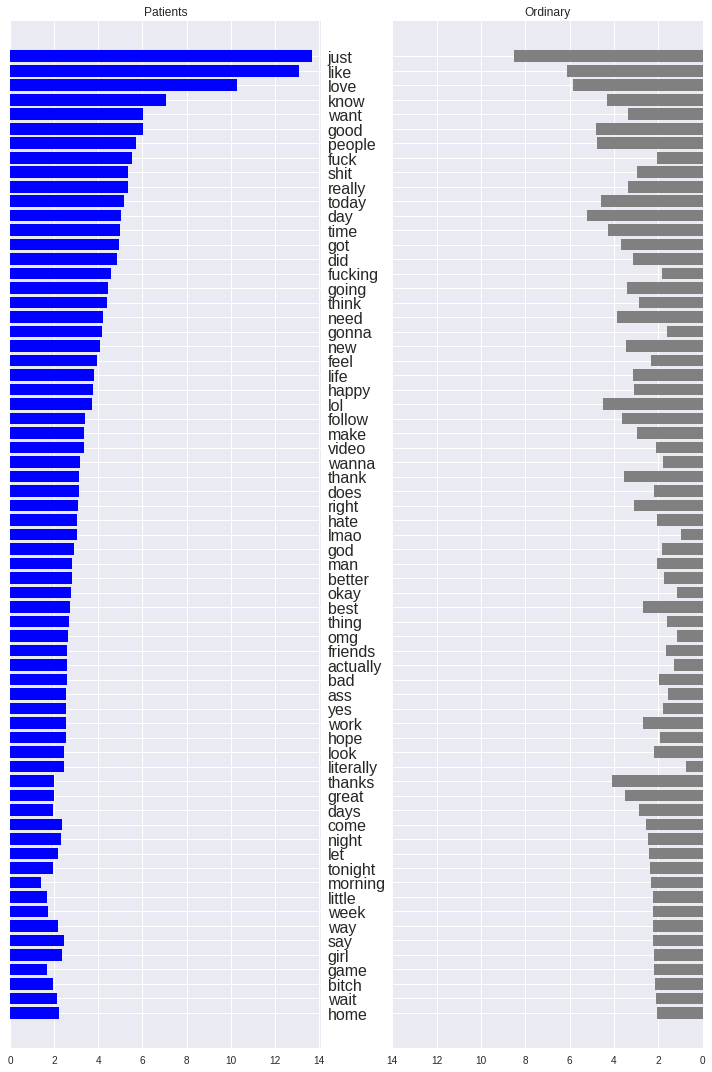

In [93]:
plotTwoGroupsTfidfType1()

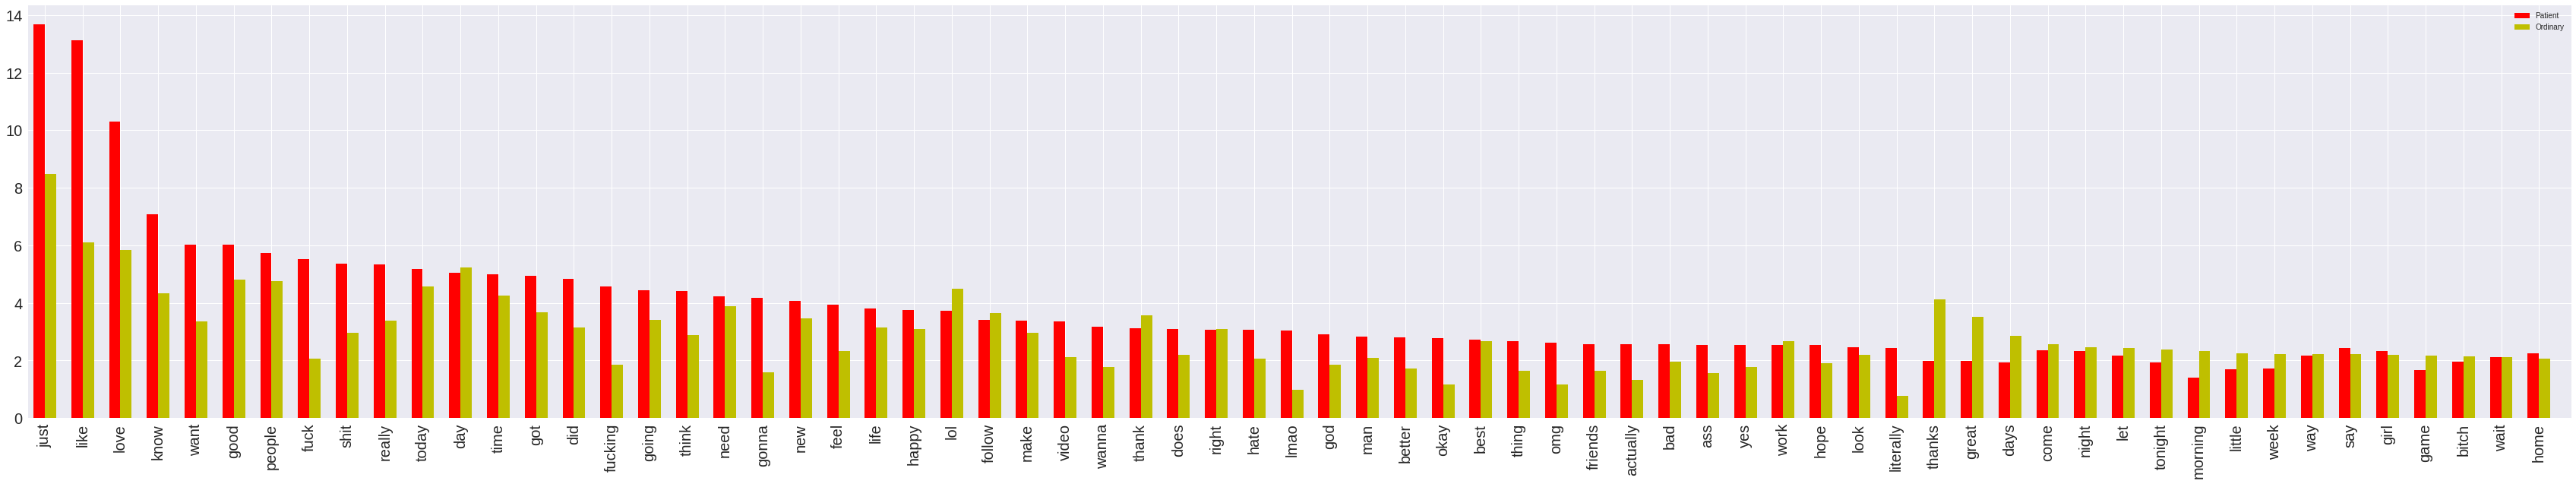